In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
import tonic
import tonic.transforms as transforms

c:\Users\mahia\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
N_FRAMES = 60

frame_transform = transforms.ToFrame(
    sensor_size=tonic.datasets.DVSGesture.sensor_size,
    n_time_bins=N_FRAMES
)

In [5]:
train_dataset = tonic.datasets.DVSGesture(save_to='./newdata', train=True, transform=frame_transform)
test_dataset  = tonic.datasets.DVSGesture(save_to='./newdata', train=False, transform=frame_transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 1077, Test samples: 264


In [8]:
frames, labels = next(iter(train_loader))
print("Frames shape:", frames.shape)
print("Labels:", labels)

Frames shape: torch.Size([8, 60, 2, 128, 128])
Labels: tensor([ 6, 10,  5,  5,  3,  7,  9, 10])


In [9]:
frames = frames.permute(0, 2, 1, 3, 4)

In [10]:
frames, labels = next(iter(train_loader))
print(frames.dtype)

torch.int16


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
class Gesture3DCNN(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d((1, 2, 2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d((2, 2, 2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d((2, 2, 2))

        self.gap = nn.AdaptiveAvgPool3d((1, 4, 4))
        self.fc  = nn.Linear(128 * 1 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [14]:
model = Gesture3DCNN(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 4

In [15]:
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for frames, labels in train_loader:
        frames = frames.permute(0, 2, 1, 3, 4).float().to(device)
        labels = labels.to(device)

        max_vals = frames.amax(dim=(2, 3, 4), keepdim=True)
        frames = frames / (max_vals + 1e-6)

        optimizer.zero_grad()
        logits = model(frames)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        correct += (logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for frames, labels in test_loader:
            frames = frames.permute(0, 2, 1, 3, 4).float().to(device)
            max_vals = frames.amax(dim=(2, 3, 4), keepdim=True)
            frames = frames / (max_vals + 1e-6)

            labels = labels.to(device)
            logits = model(frames)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)

    print(f"           Test Acc: {correct/total:.3f}")

Epoch 01 | Train Loss: 1.3732 | Train Acc: 0.484
           Test Acc: 0.557
Epoch 02 | Train Loss: 0.9110 | Train Acc: 0.625
           Test Acc: 0.621
Epoch 03 | Train Loss: 0.6831 | Train Acc: 0.730
           Test Acc: 0.765
Epoch 04 | Train Loss: 0.4275 | Train Acc: 0.859
           Test Acc: 0.841


In [16]:
# Get predictions
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for frames, labels in test_loader:
        frames = frames.permute(0, 2, 1, 3, 4).float().to(device)
        max_vals = frames.amax(dim=(2, 3, 4), keepdim=True)
        frames = frames / (max_vals + 1e-6)
        labels = labels.to(device)
        logits = model(frames)
        preds = logits.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print(report)

                 precision    recall  f1-score   support

  Hand clapping       0.71      0.71      0.71        24
Right hand wave       0.86      1.00      0.92        24
 Left hand wave       0.96      1.00      0.98        24
   Right arm cw       0.95      0.79      0.86        24
  Right arm ccw       0.88      0.92      0.90        24
    Left arm cw       0.85      0.96      0.90        24
   Left arm ccw       1.00      1.00      1.00        24
       Arm roll       0.93      0.58      0.72        24
      Air drums       0.55      0.75      0.63        24
     Air guitar       0.89      0.67      0.76        24
 Other gestures       0.84      0.88      0.86        24

       accuracy                           0.84       264
      macro avg       0.86      0.84      0.84       264
   weighted avg       0.86      0.84      0.84       264



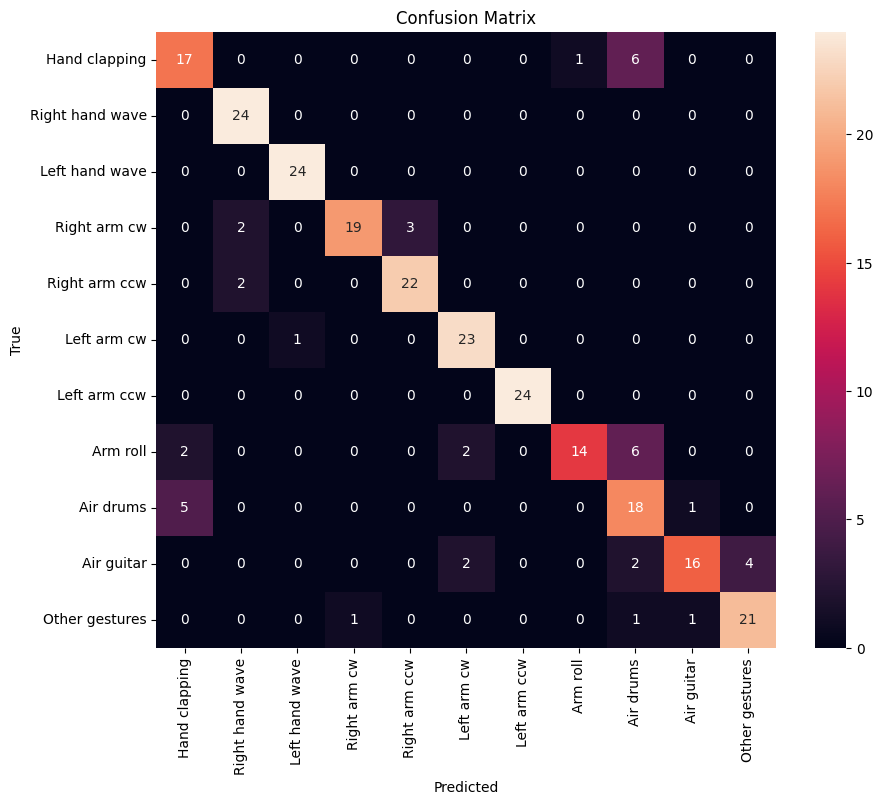

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()